# Data Analytics and Classification Model for Failure Detection of Wind Turbine from IIoT Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#os.getcwd() = TEAM-2-2024Fall/eda



In [8]:
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import plot_confusion_matrix, classification_report
# from lightgbm import LGBMClassifier

%config InlineBackend.figure_format = 'retina'

# 1. Read data

We have 3 data:

* `scada_data.csv`: Contains >60 information (or status) of wind turbine components recorded by SCADA system
* `fault_data.csv`: Contains wind turbine fault types (or modes)
* `status_data.csv`: Contains description of status of wind turbine operational

not there yet
eda


In [15]:
# acess the raw data file in data/raw

TO_DATA_FOLDER = '../data/raw/'
os.chdir(TO_DATA_FOLDER) # run it once. Comment this line when you directory of os.getcwd() is already in data/raw/


print(os.getcwd())
print(os.listdir())


scada_df = pd.read_csv('scada.csv')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'], format = "%m/%d/%Y %H:%M")
scada_df.set_index('DateTime', inplace=True)

scada_df

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/raw/'

In [16]:
status_df = pd.read_csv('status.csv')
status_df['Time'] = pd.to_datetime(status_df['Time'])
status_df.rename(columns={'Time': 'DateTime'}, inplace=True)
status_df.set_index('DateTime', inplace=True)

status_df

,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
DateTime,,,,,,,,
2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6
...,...,...,...,...,...,...,...,...
2015-04-27 07:26:51,0,0,0 : 0,Turbine in operation,1,False,False,7.0
2015-04-28 22:14:25,26,373,26 : 373,Malfunction fan-inverter : Other control board...,6,False,False,8.1
2015-04-28 22:14:53,0,2,0 : 2,Turbine operational,1,False,False,9.5


In [17]:
fault_df = pd.read_csv('fault.csv')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])
fault_df.set_index('DateTime', inplace=True)

fault_df

,Time,Fault
DateTime,,
2014-05-14 14:39:44,1.400096e+09,GF
2014-05-14 14:50:24,1.400097e+09,GF
2014-05-14 14:58:56,1.400098e+09,GF
2014-05-14 15:09:36,1.400098e+09,GF
2014-05-14 15:20:16,1.400099e+09,GF
...,...,...
2015-01-14 23:00:48,1.421298e+09,AF
2015-01-14 23:09:20,1.421299e+09,AF
2015-01-15 22:50:08,1.421384e+09,AF


In the fault data, there are 5 types of faults, or fault modes:

* gf: generator heating fault
* mf: mains failure fault
* ff: feeding fault
* af: air cooling fault
* ef: excitation fault

I don't know exactly what these are. The source of these fault modes in this [GitHub](https://github.com/lkev/wt-fdd).

In [18]:

scada_df.describe()

,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
count,4.902700e+04,49027.000000,49027.000000,49027.000000,49027.000000,49027.00000,49027.000000,49027.000000,49027.000000,49027.000000,...,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000,49027.000000
mean,1.413762e+09,0.938748,6.874626,9.340286,12.244133,8.67852,9.547354,8.515034,942.261244,1214.015400,...,30.335958,24.320211,28.802456,13.380219,23.116303,31.766537,43.992596,2988.628184,27.828410,1.855781
std,8.559693e+06,14.442141,3.694776,5.157448,223.186866,4.14345,4.482192,22.394531,1008.930159,1168.858993,...,5.623608,4.918045,5.185007,5.246230,6.360604,6.381892,10.404843,172.074485,5.595795,1.269928
min,1.398920e+09,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,-14.000000,0.000000
25%,1.406352e+09,0.000000,4.200000,5.800000,2.600000,6.33000,6.740000,5.880000,87.000000,138.000000,...,26.000000,20.000000,25.000000,9.000000,19.000000,27.000000,37.000000,3050.000000,24.363636,1.206045
50%,1.413706e+09,0.000000,6.500000,8.600000,4.400000,8.97000,10.060000,7.850000,536.000000,802.000000,...,30.000000,25.000000,29.000000,13.000000,24.000000,33.000000,43.000000,3050.000000,28.454546,1.566699
75%,1.421179e+09,0.000000,8.900000,11.700000,6.300000,11.92000,13.550000,10.390000,1551.000000,2326.000000,...,34.000000,28.000000,33.000000,17.000000,28.000000,36.000000,48.000000,3050.000000,31.818182,2.370270
max,1.428556e+09,246.000000,32.099998,51.099998,6553.500000,14.73000,18.910000,655.349976,3071.000000,3216.000000,...,49.000000,38.000000,44.000000,35.000000,36.000000,45.000000,71.000000,3050.000000,42.545456,23.512859


# 2. Analyze Scada Data

The 3 data have different time spans. The status data has the longest record timespan from January 2014 to December 2015. The shortest is SCADA data from April 2014 to April 2015. Therefore, when seeing the SCADA records, we can refer to status and fault data to see what happens on the turbine at certain timestamps.

(0.0, 4.0)

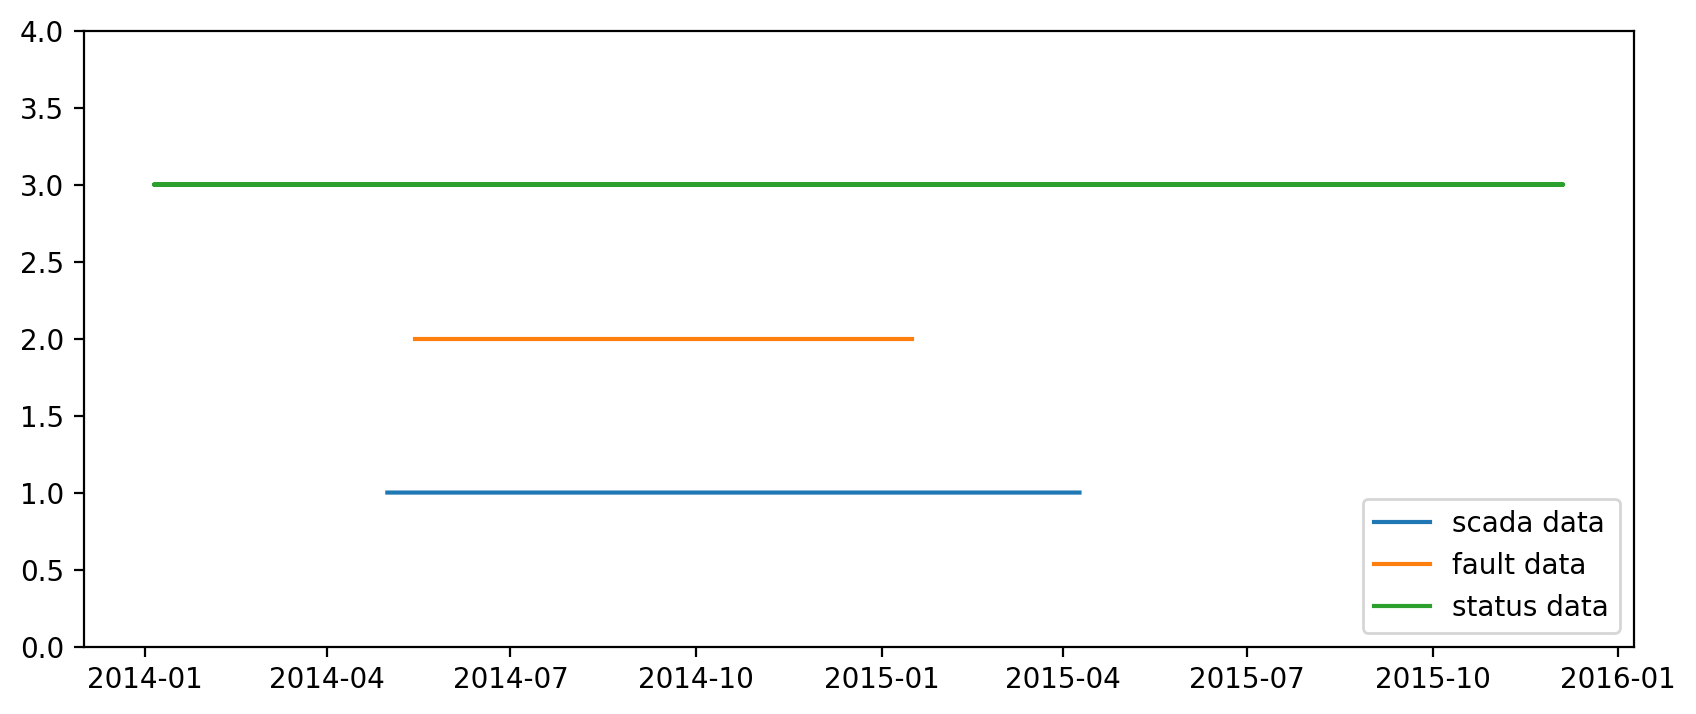

In [19]:
# Plot time span of all data
t_scada = scada_df.index
t_fault = fault_df.index
t_status = status_df.index

plt.figure(figsize=(10,4))
plt.plot(t_scada, np.full(len(scada_df), 1), label='scada data')
plt.plot(t_fault, np.full(len(fault_df), 2), label='fault data')
plt.plot(t_status, np.full(len(status_df), 3), label='status data')
plt.legend(loc='lower right')
plt.ylim(0,4)

<Axes: xlabel='DateTime'>

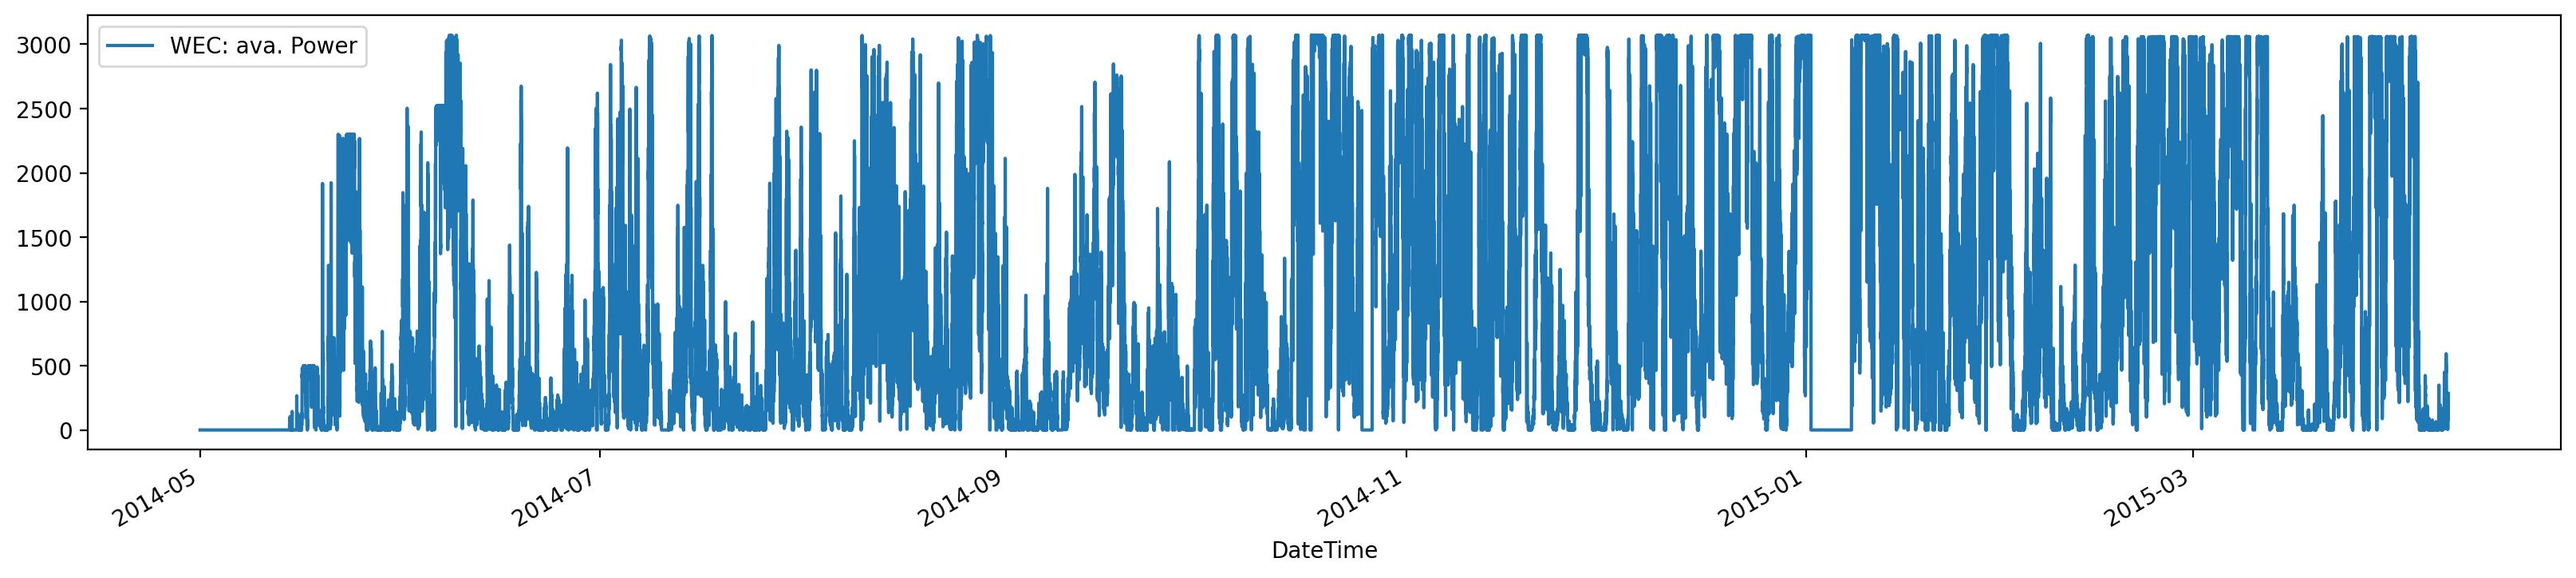

In [20]:
# Plot of max power from SCADA data
scada_df.plot(y='WEC: ava. Power', figsize=(20,4))

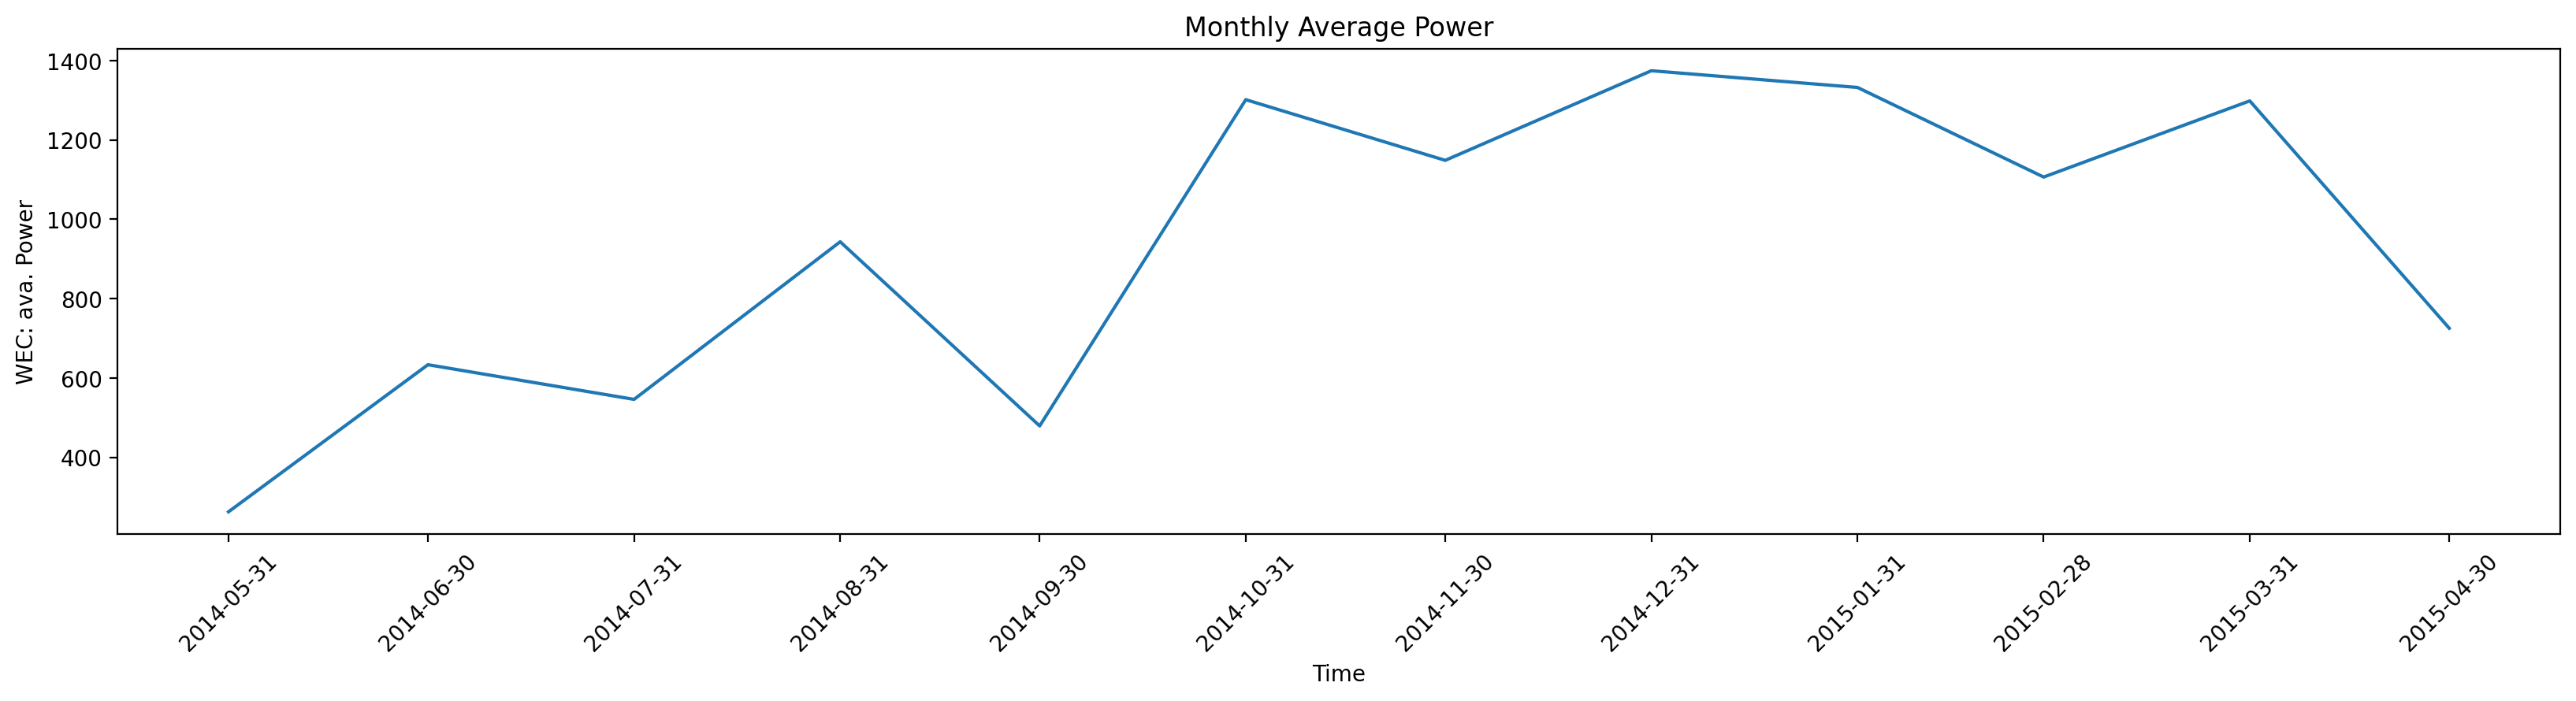

In [21]:
# Plot of avg power output generated by the wind turbine on a monthly basis

monthly_scada_df = scada_df.resample("M").mean()
plt.figure(figsize=(20, 4))
plt.plot(monthly_scada_df.index, monthly_scada_df['WEC: ava. Power'])

# Customize x-axis labels
plt.xticks(monthly_scada_df.index, rotation=45)

# Set x-axis label
plt.xlabel('Time')
# Set y-axis label
plt.ylabel('WEC: ava. Power')
plt.title('Monthly Average Power')

plt.show()

From the above graph, we notice that from October to March, we can observe a rising trend of power generated by wind turbine and stay on a high pleatue
There were times when power dropped, for example in October 2014, December 2014, and the most significant in January 2015. However, by monthly average of the generated power, we can conclude that in Winter and Spring we have relatively higher power that can be sold.

The number of wind turbine faults significantly increases on October 2014.

# 3. Analyze the Fault Data

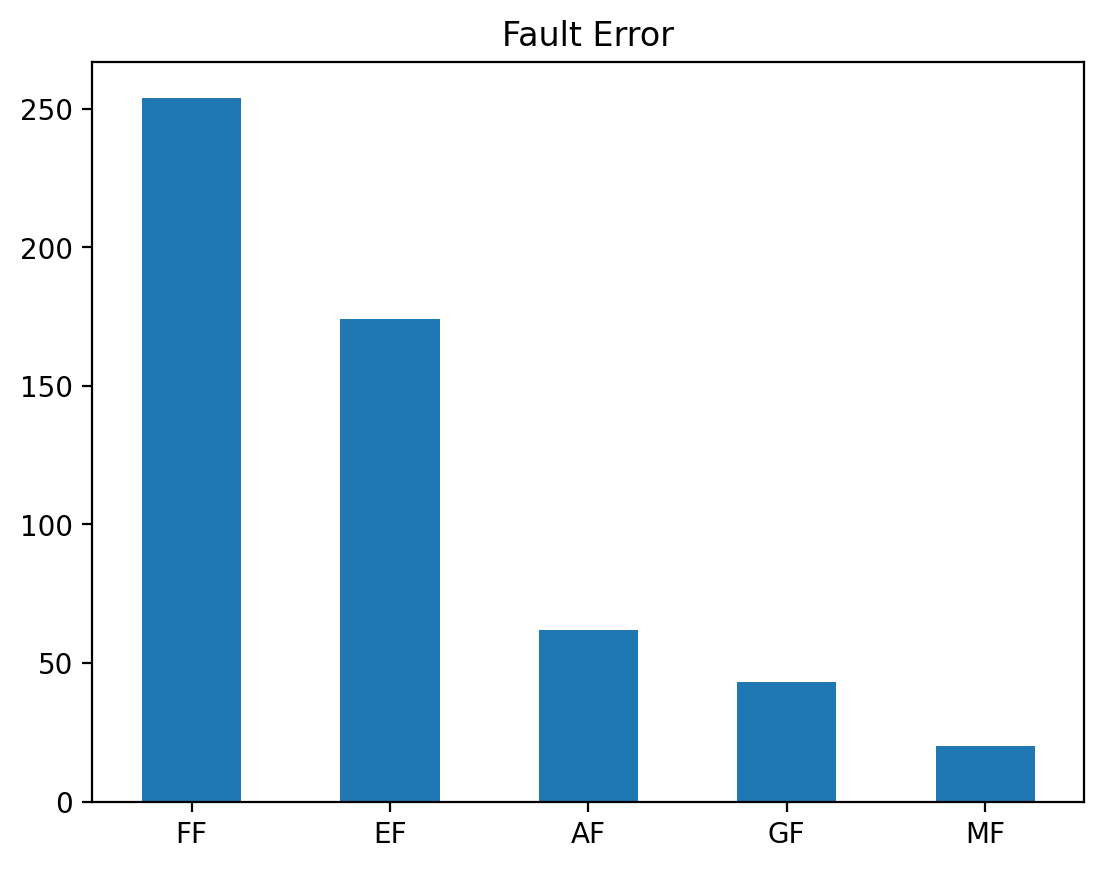

In [22]:
# To visual the Fault Type and its total occurence

fault_df["Fault"].value_counts().plot(kind='bar', title="Fault Error",rot=0)
plt.show()

## All types of fault
- 1. gf: generator heating fault  
- 2. mf: mains failure fault  
- 3. ff: feeding fault  
- 4. af: air cooling fault  
- 5. ef: excitation fault

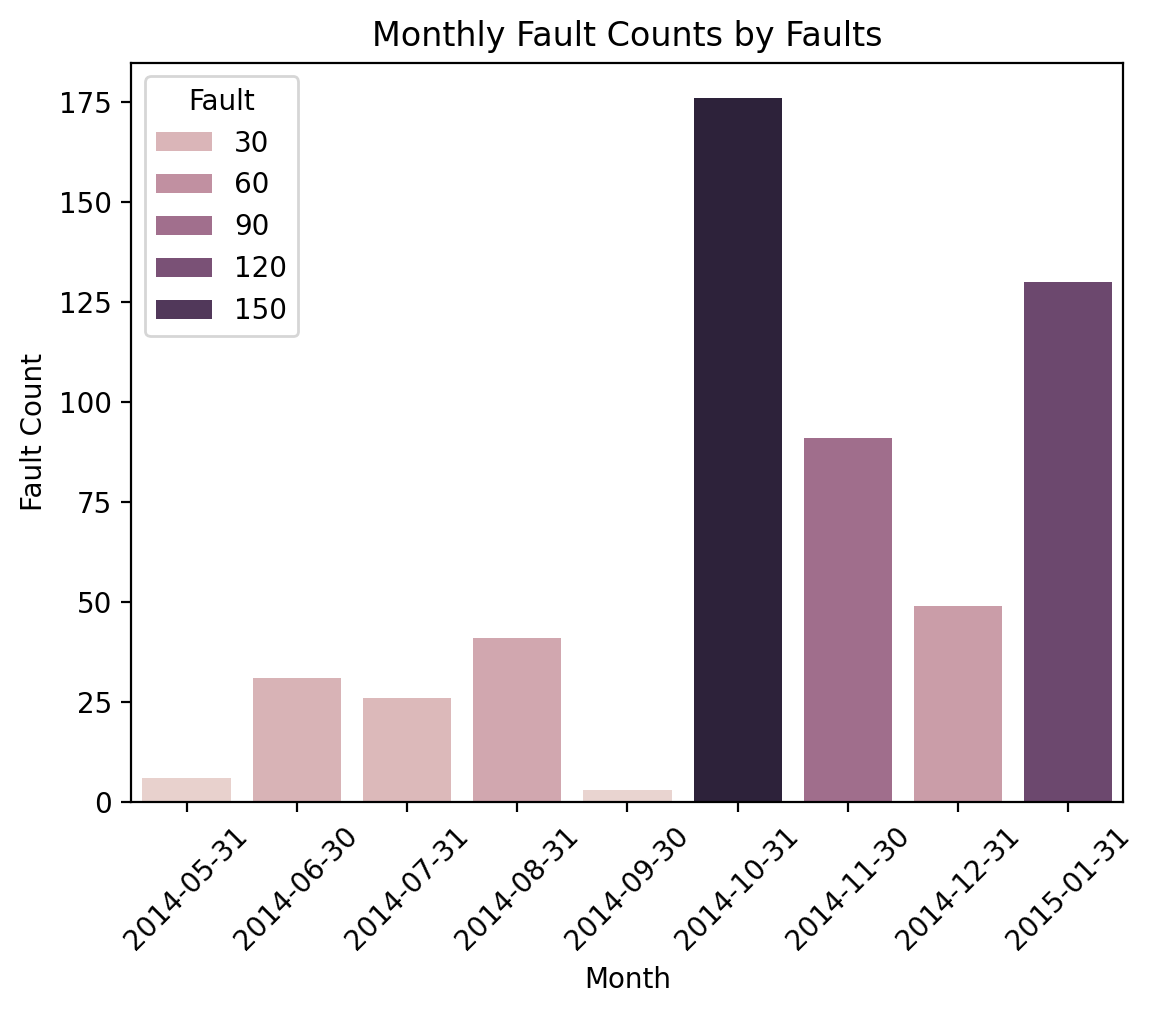

In [34]:
# Plot of number of faults on monthly resampled data

#fault_df.resample('M')['Fault'].count().plot.bar()
# Create the bar plot with extracted counts
# Resample and count faults
fault_counts = fault_df.resample('M')['Fault'].count()

sns.barplot(x=fault_counts.index, y=fault_counts.values, hue=fault_counts)  # Use index for both x and hue

plt.xlabel('Month')  # Adjust label if applicable
plt.ylabel('Fault Count')
plt.title('Monthly Fault Counts by Faults')
plt.xticks(rotation=45)
plt.show()

Based on the plot above and previous analysis of the Scada data, we observe that there are more faults in high production season(from 2014 winter to 2015 spring). 
Such a finding aligns with ours expectation, since more power generated means more workload on the turbine and this can possibly lead to more frequent faults and more intense maintainence.

## 3.1 Further Fault Analysis
It is good that we realize the error-prone season to deploy our maintainence team effectively. It is going to be better if for each season, we know what types of faults we are more likely to face, which can hire or deploy specific team to handle the problem, making the maintainence process even more efficient. Therefore, we intend to plot a stacked bar plot to have better analysis.

In [40]:
# The stats for each faults in each month

fault_df.resample('M')["Fault"].value_counts()

DateTime    Fault
2014-05-31  GF        6
2014-06-30  AF       15
            MF       14
            FF        2
2014-07-31  AF       10
            EF        8
            FF        6
            MF        2
2014-08-31  AF       28
            EF        7
            FF        6
2014-09-30  AF        3
2014-10-31  EF       93
            FF       68
            GF       11
            MF        4
2014-11-30  EF       66
            FF       25
2014-12-31  FF       49
2015-01-31  FF       98
            GF       26
            AF        6
Name: Fault, dtype: int64

Plot the faults grouped by its fault modes. There are lots of EF events in October and November 2014, and lots of FF events from October 2014 - January 2015.

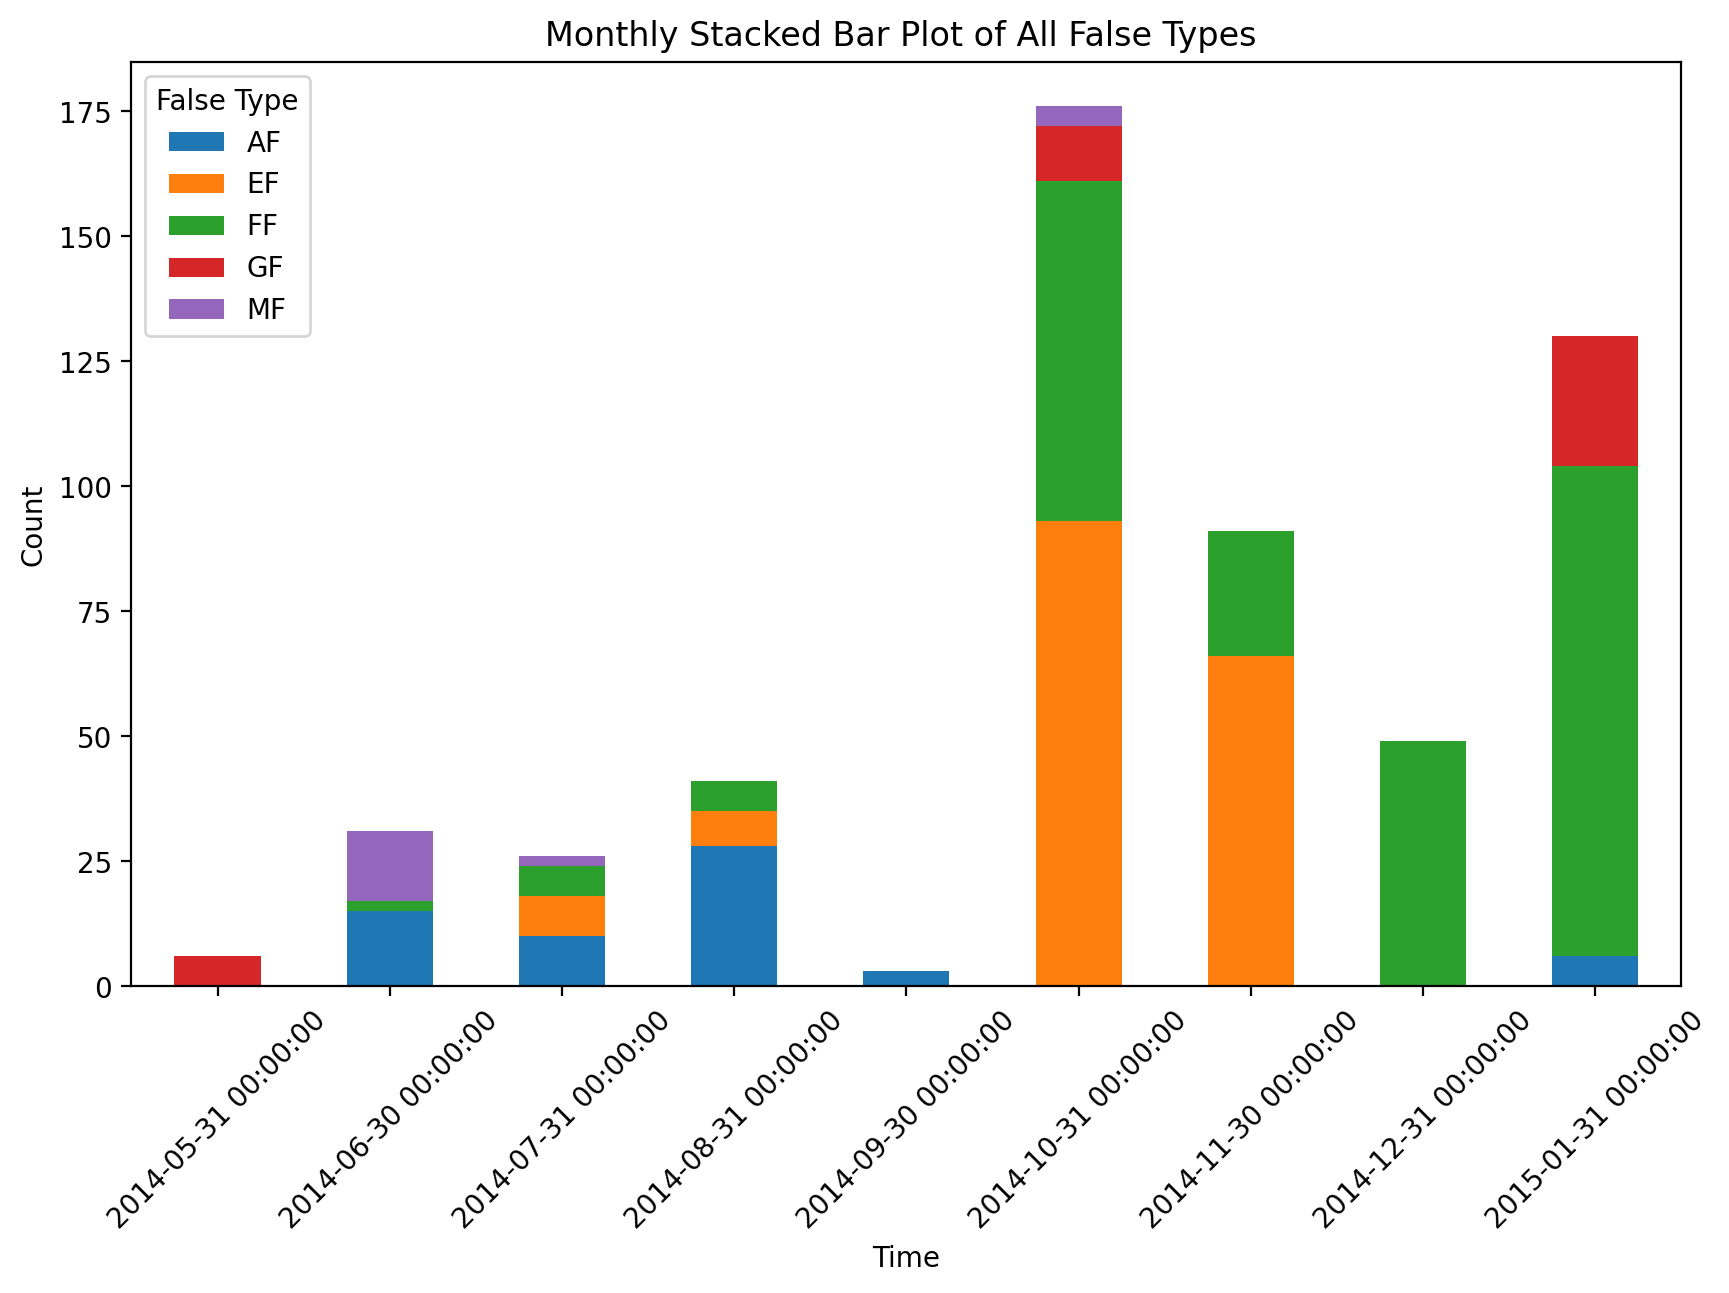

In [47]:
# Group by datetime(Monthlt) and category, then count occurrences

grouped_df = fault_df.resample("M")["Fault"].value_counts().unstack()

# Plot the stacked bar chart

grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add label and legend to the plot
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Monthly Stacked Bar Plot of All False Types ')
plt.xticks(rotation=45)
plt.legend(title='False Type',loc="upper left")

plt.show()

# 3. Combine SCADA and Faults data

From previous analysis, we find that the SCADA and fault data mainly overlapped and we, unfortunately, we don't have good explanation for the status data. Therefore, we merely combine the SCADA and fault data to further our analysis.

In [59]:
# Combine scada and fault data
combine_df = pd.merge_asof(fault_df,scada_df, left_index=True, right_index=True, direction='nearest')

#msno.matrix(combine_df)
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2014-05-14 14:39:44 to 2015-01-15 23:09:20
Data columns (total 67 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Time_x                                             553 non-null    float64
 1   Fault                                              553 non-null    object 
 2   Time_y                                             553 non-null    int64  
 3   Error                                              553 non-null    int64  
 4   WEC: ava. windspeed                                553 non-null    float64
 5   WEC: max. windspeed                                553 non-null    float64
 6   WEC: min. windspeed                                553 non-null    float64
 7   WEC: ava. Rotation                                 553 non-null    float64
 8   WEC: max. Rotation                                 55

In [ ]:
# Select the following columns, 'Fault', 'WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power','WEC: Operating Hours','WEC: Production kWh', 'WEC: Production minutes'

selected_combine_df = combine_df.loc[:, ['Fault', 'WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power','WEC: Operating Hours','WEC: Production kWh', 'WEC: Production minutes']]
selected_combine_df

,Fault,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: Operating Hours,WEC: Production kWh,WEC: Production minutes
DateTime,,,,,,,
2014-05-14 14:39:44,GF,0,0,0,881,939053,6
2014-05-14 14:50:24,GF,0,0,0,881,939053,6
2014-05-14 14:58:56,GF,0,0,0,881,939053,6
2014-05-14 15:09:36,GF,0,0,0,881,939053,6
2014-05-14 15:20:16,GF,0,0,0,881,939053,6
...,...,...,...,...,...,...,...
2015-01-14 23:00:48,AF,2736,2798,2417,6041,6159273,9
2015-01-14 23:09:20,AF,20,2746,0,6041,6159276,9
2015-01-15 22:50:08,AF,1667,1914,1259,6064,6215339,47


# 4. More Exploratory Data Analysis (Can have more content)
We can probably analyze the tempature data to have a better prediction of reoccurence of eahc fault